In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import beta

For simplicity, we will demonstrate nested sampling in a 2-dimension unit square, $\mathbf{x}=(x_0, x_1)$, with the uniform prior 
$$ \pi(\mathbf{x}) = \begin{cases} 1 \quad \mathrm{if} \; 0\leq x_0, x_1 \leq 1\\ 0 \quad \mathrm{else} \end{cases} . $$

We will explore the following simple likelihood function with exponent $\epsilon=2$,
$$ \mathcal{L}(d|\mathbf{x}) = ((x_0 x_1 (1-x_0) (1-x_1))^{\epsilon} . $$  

For this toy problem, the evidence can be calculated analytically; the result is expressed in terms of the beta function,
$$ Z = \int_0^1\mathrm{d}x_0\;\int_0^1\mathrm{d}x_1\; \mathcal{L}(d|\mathbf{x}) \pi(\mathbf{x}) = B(\epsilon+1, \epsilon+1)^2 . $$
We will use this as a check on our nested sampling.

In [86]:
class nested_sampling_demo():

    def __init__(self, exponent=2., num_live=10):
        """ initialise nested sampling demo """
        self.dim = 2
        self.exponent = exponent
        self.num_live = num_live

        # the exact, analytic evidence (for testing)
        self.Zexact = beta(self.exponent+1, self.exponent+1)**2

        self.centre_point = 0.5 * np.ones(self.dim)
        self.peak_logL = self.log_likelihood(self.centre_point)

        self.live_points = [ self.prior_sample() for j in range(self.num_live) ]
        self.live_loglikelihoods = [ self.log_likelihood(x) for x in self.live_points ]

        self.xis = [1.]
        self.samples = []
        self.weights = []
        self.logLs = [-np.inf]
        self.dead_point = None
        
        self.iteration = 0

    def log_likelihood(self, x):
        """ the log-likelihood function $\log\mathcal{L}(d|x)$ """
        return self.exponent * ( np.sum(np.log(x)) + np.sum(np.log(1-x)) ) 

    def prior_sample(self, logL=-np.inf):
        """ sample the prior with constraint likelihood > L """
        assert logL<self.peak_logL, "Warning: logL is too large"
        accept = False
        while not accept:
            x = np.random.uniform(size=2)
            accept = (self.log_likelihood(x)>logL)
        return x

    def _iterate(self):
        """ perform one iteration of nested sampling algorithm """
        self.iteration += 1

        idx_min = np.argmin(self.live_loglikelihoods)

        self.samples.append(self.live_points[idx_min])
        
        self.xis.append(np.exp(-self.iteration/self.num_live))
        
        self.weights.append( np.exp(-(self.iteration-1)/self.num_live) - np.exp(-(self.iteration)/self.num_live) )
        
        self.logLs.append(self.live_loglikelihoods[idx_min])
        
        self.dead_point = self.live_points[idx_min]
        
        self.replacement = self.prior_sample(logL=self.live_loglikelihoods[idx_min])
        
        self.live_points[idx_min] = self.replacement
        
        self.live_loglikelihoods[idx_min] = self.log_likelihood(self.live_points[idx_min])

    def iterate(self, num_iter=1):
        """ iterate and plot """
        for i in range(num_iter):
            self._iterate()
        self.plot()

    def plot(self):
        """ make plots showing current state of the algorithm """
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

        # 
        border = 1.0e-3
        x = np.linspace(border, 1-border, 50)
        y = np.linspace(border, 1-border, 50)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)
        for i, x_ in enumerate(x):
            for j, y_ in enumerate(y):
                Z[i,j] = np.exp(self.log_likelihood(np.array([x_,y_])))
        axs[0].contourf(X, Y, Z, 16, alpha=0.1)
        axs[0].contour(X, Y, Z, [np.exp(self.log_likelihood(self.dead_point))], colors='C1', linewidths=1)
        
        axs[0].set_title(r'$N_{\rm live}='+str(self.num_live)+'$ Points In Sample Space')
        pts = np.array(self.live_points)
        axs[0].scatter(pts[:,0], pts[:,1], color='C0')
        axs[0].scatter(self.dead_point[0], self.dead_point[1], s=70, label='worst point ($\log\mathcal{L}='+
                       '{:.1e}'.format(self.log_likelihood(self.dead_point))+'$)', color='C1')
        axs[0].scatter(self.replacement[0], self.replacement[1], s=70, label='replacement ($\log\mathcal{L}='+
                       '{:.1e}'.format(self.log_likelihood(self.replacement))+'$)', color='C2')
        axs[0].arrow(self.dead_point[0], self.dead_point[1],
                     self.replacement[0]-self.dead_point[0], self.replacement[1]-self.dead_point[1],
                     color='grey', length_includes_head=True, width=1.5e-3, head_width=2.0e-2, alpha=0.3)
        axs[0].set_xlim(0,1)
        axs[0].set_ylim(0,1)
        axs[0].set_aspect('equal')
        axs[0].set_xlabel(r'$x_0$')
        axs[0].set_ylabel(r'$x_1$')
        axs[0].legend(loc='upper right', frameon=True)

        # 
        axs[1].set_title('The Likelihood Vs Prior Mass')
        axs[1].plot(self.xis, np.exp(self.logLs), color='C0')
        if self.iteration<40:
            axs[1].scatter(self.xis, np.exp(self.logLs), color='C0', s=20)
        axs[1].scatter(self.xis[-1], np.exp(self.log_likelihood(self.dead_point)), color='C1', s=70, 
                       label='worst point')
        for i in range(len(self.xis[1:])):
            axs[1].plot([self.xis[i+1],self.xis[i+1]], [0, np.exp(self.logLs[i+1])], color='grey', lw=0.5)
        axs[1].set_xlim(0,1)
        axs[1].set_ylim(0,1.05*np.exp(self.logLs[-1]))
        axs[1].set_xlabel(r'$\xi$')
        axs[1].set_ylabel(r'$L(\xi)$')
        if min(self.xis)>0.25:
            axs[1].annotate('', xy=(0,0.45*max(np.exp(self.logLs))), 
                            xytext=(min(self.xis),0.45*max(np.exp(self.logLs))), 
                            arrowprops=dict(arrowstyle='<->', color='C2', lw=3))
            axs[1].text(0.2*min(self.xis), 0.5*max(np.exp(self.logLs)),
                            'replacement point\n goes in here', color='C2') 
        axs[1].legend(loc='upper right', frameon=True)
        
        #
        axs[2].set_title('Evidence Estimate')
        iter = np.arange(1, 1+self.iteration)
        Zest = np.cumsum(np.array(self.weights)*np.exp(self.logLs[1:]))
        axs[2].plot(iter,Zest, color='C0')
        if self.iteration<40:
            axs[2].scatter(iter,Zest, color='C0', s=20)
        dZ = 0.05*self.Zexact*np.ones_like(iter)
        axs[2].fill_between(iter, Zest-dZ, Zest+dZ, color='C0', alpha=0.2)
        axs[2].axhline(self.Zexact, color='k', ls=':', label='analytic value')
        axs[2].set_xlabel(r'Iteration $i$')
        axs[2].set_ylabel(r'$Z$')
        axs[2].legend(loc='lower right')
        axs[2].set_xlim(0,self.iteration)
        axs[2].set_ylim(0,1.05*max(self.Zexact, np.sum(np.array(self.weights)*np.exp(self.logLs[1:]))))

        plt.show()

NS = nested_sampling_demo(num_live=10)

Run the following cell multiple times to see how the nested sampling algorithm behaves.

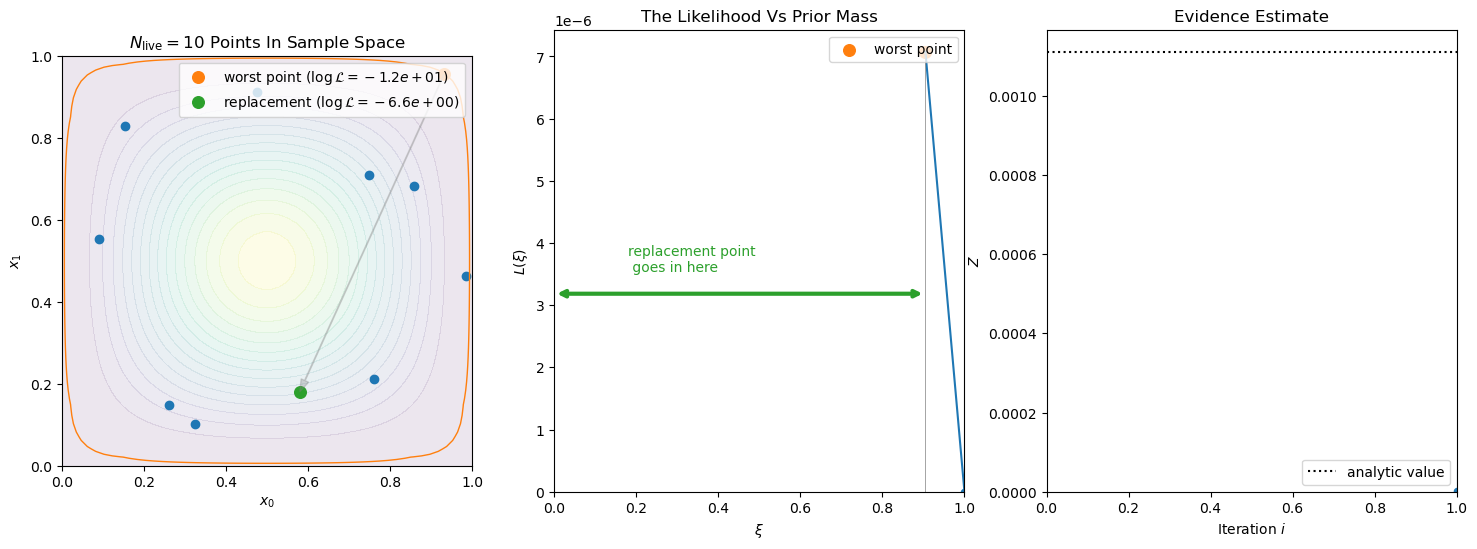

In [87]:
NS.iterate(num_iter=1)